## Taken from Erin's note

In [8]:
import glob,sys
sys.path.insert(0, '../../')
sys.path.insert(0, '/home/jk11/pyathena')

import matplotlib.pyplot as plt
from scipy.integrate import quad, trapz
import numpy as np
import pandas as pd
from astropy import units as u
import xarray as xr
import tigradpy as tp

import pyathena as pa
units=pa.set_units(muH=1.4271)
plt.rcParams['font.size'] = 14.

In [9]:
from tigradpy import mass_to_lum

MtoL = mass_to_lum(model='SB99')

In [10]:
probname = 'R8_4pc_newacc'
pid = 1
tidx = 230

def gen_cgfiles ( probname, pid, tidx ):
    probdir = '/tigress/changgoo/{0}'.format(probname)
    starfile = '{0}/starpar/{1}.{2}.starpar.vtk'.format(probdir, probname, str(tidx).zfill(4))
    probfile = '{0}/id{2}/{1}-id{2}.{3}.vtk'.format(probdir, probname, pid, str(tidx).zfill(4))
    return probfile, starfile

In [11]:
def get_meanrunawaymass ( lmass=8., hmass=120.):
    propdensity = lambda x: x**(-1.35)
    normalization = lambda x: x**-2.35
    mbar = quad ( propdensity, lmass, hmass )[0] / quad( normalization, lmass, hmass)[0]
    return mbar

def pull_runawaymass ( N, lmass=8., hmass=120. ):
    '''
    Inverse transform sampling with a Salpeter IMF
    '''
    _imf = lambda x: x**-2.35
    Z = quad( _imf, lmass, hmass)[0]
    pdf = lambda x: _imf(x) / Z
    #cdf = lambda mass: (Z*-1.35)**-1 * (mass**-1.35 - 8.**-1.35)
    inv_cdf = lambda rv: (-1.35 * Z * rv + lmass**-1.35)**(1/-1.35)

    mass_pulls = inv_cdf ( np.random.uniform(0,1,N))
    return pdf,mass_pulls


def find_activeparticles ( starpardata, max_runawayage=10.*u.Myr, max_clusterage=40.*u.Myr):
    runaways = starpardata.query('(mass==0.)&(mage<%f)' % (max_runawayage / units['time'] ))
    clusters = starpardata.query('(mass>0.)&(mage<%f)' % (max_clusterage / units['time'] ))
    if runaways.shape[0] > 0:
        assert max(runaways['mage']) < (max_runawayage / units['time'])
    if clusters.shape[0] > 0:
        assert max(clusters['mage']) < (max_clusterage / units['time'])
    return runaways, clusters

def compute_runawayq (runaways, use_mean=False, **kwargs):
    if use_mean:
        rlum = MtoL.calc_Qi ( np.ones(runaways.shape[0]) * get_meanrunawaymass (**kwargs),
                                runaways['mage'] * units['time'] )
    else:
        rlum = MtoL.calc_Qi ( pull_runawaymass(runaways.shape[0])[1], # already in Msun units
                                 runaways['mage'] * units['time']
                                )
    return rlum
    
def compute_clusterq ( clusters, **kwargs):
    clum = MtoL.calc_Qi(clusters.loc[:,'mass']*units['mass'].value, 
                            clusters.loc[:,'mage']*units['time'])
    return clum


(19.23716721681448, 19.398588286732235)


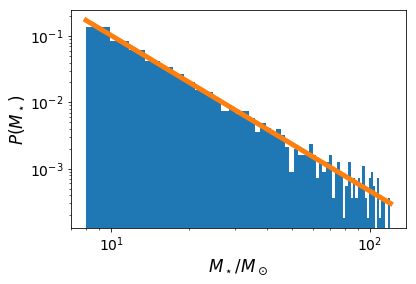

In [12]:
pdf,mass = pull_runawaymass (3000)
# Sanity check on inverse and mean methods
xs = np.linspace(8.,120.,1000)
plt.hist(mass, density=True, bins=60)
plt.plot(xs, pdf(xs), lw=5)

plt.xlabel (r'$M_\star/M_\odot$')
plt.ylabel (r'$P(M_\star)$')
plt.loglog()
print(mass.mean(), get_meanrunawaymass())


In [13]:
ovlstars = []
time = []
N_runaways = []
N_clusters = []
q_runaways = []
q_clusters = []
q_runaways_alt = []
MtoL_alt = tp.mass_to_lum(model='Padova')

for t in range(675):

    sparticles = pa.read_starvtk ( gen_cgfiles(probname, pid, t )[1] )
    
    if sparticles.shape[0] == 0:
        continue

    runaways, clusters = find_activeparticles ( sparticles )    
    q_runaways.append ( compute_runawayq(runaways).sum() )
    q_clusters.append ( compute_clusterq(clusters).sum() )
    N_runaways.append( runaways.shape[0]) 
    N_clusters.append ( clusters.shape[0])
    time.append ( t * units['time'].value )
    
    MS_age = np.array(runaways['mage'] - runaways['age'])
    MS_age = MS_age[(MS_age > 2.73)] + 4.0
    
    mass = MtoL_alt.age_to_mass(MS_age)
    q_runaways_alt.append(MtoL_alt.Qi(mass).sum())
    
N_runaways = np.asarray (N_runaways)
N_clusters = np.asarray ( N_clusters)
q_runaways = np.asarray ( q_runaways)
q_runaways_alt = np.asarray ( q_runaways_alt )
q_clusters = np.asarray ( q_clusters )

Text(0,0.5,'$Q_{i,\\rm runaway} / Q_{\\rm tot}$')

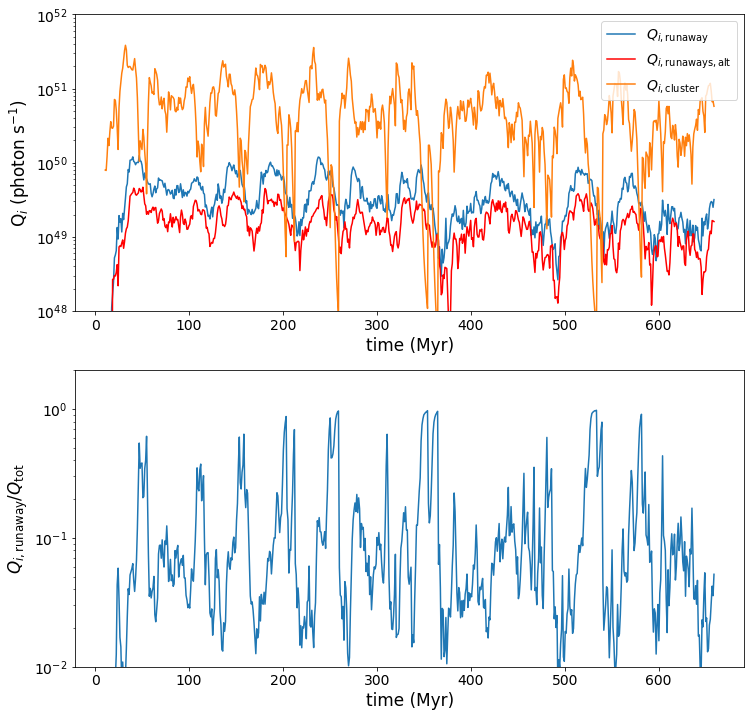

In [16]:
fig, axarr= plt.subplots ( 2,1, figsize=(12,12)) #axarr.figure(figsize=(12,6))
axarr[0].plot ( time, q_runaways, label=r'$Q_{i,\rm runaway}$' )
axarr[0].plot ( time, q_runaways_alt, 'r-', label=r'$Q_{i,\rm runaways,alt}$' )
axarr[0].plot ( time, q_clusters, label=r'$Q_{i,\rm cluster}$' )
axarr[0].set_yscale('log')
axarr[0].set_xlabel ( 'time (Myr)')
axarr[0].set_ylabel (r'Q$_i$ (photon s$^{-1}$)')
axarr[0].legend()
axarr[0].set_ylim(1e48,1e52)

axarr[1].plot ( time, q_runaways / (q_runaways + q_clusters))
axarr[1].set_yscale('log')
axarr[1].set_ylim(0.01,2)
axarr[1].set_xlabel ( 'time (Myr)')
axarr[1].set_ylabel ( r'$Q_{i,\rm runaway} / Q_{\rm tot}$')


## Thoughts (JGKIM)

__Runaways in starpar vtk__

__mage: parent cluster's mass-weighted age?__

__age: time left to SN explosion?__

__If this is the case and if mage gives the time after birth, then we may take (main sequnce lifetime of runaway) ~(mage - age).__

__We can then utilize the (ZAMS) mass-age relation to estimate runaway mass, and hence (mean) ionizing luminosity (see below).__

__Print list of runaways__

In [8]:
runaways

,age,flag,id,mage,mass,metal_mass0,metal_mass1,metal_mass2,time,v1,v2,v3,x1,x2,x3
1,-10.915811,-1,10314,6.794467,0.0,0.0,0.0,0.0,673.3506,-44.230194,12.614520,94.399300,-163.272842,-348.839142,671.476074
3,-1.105246,-1,10326,5.568035,0.0,0.0,0.0,0.0,673.3506,-74.717705,-5.422697,50.085449,-143.285110,398.749359,290.911957
4,-4.902719,-1,10323,6.046827,0.0,0.0,0.0,0.0,673.3506,76.853424,28.438972,46.930237,-322.193390,420.307922,298.653229
8,-21.029827,-1,10324,5.992134,0.0,0.0,0.0,0.0,673.3506,-162.418182,7.099396,21.614025,340.018921,302.038666,161.596237
21,-17.837128,-1,10328,5.528988,0.0,0.0,0.0,0.0,673.3506,4.965932,-16.993841,31.155148,312.827637,389.076843,176.237015
27,-19.383646,-1,10373,2.407113,0.0,0.0,0.0,0.0,673.3506,1.228839,6.893583,16.573439,261.112213,494.378174,34.380943
29,-19.340523,-1,10344,3.985853,0.0,0.0,0.0,0.0,673.3506,-3.357341,-39.505043,2.025148,261.492249,326.966400,2.878133
31,-1.895717,-1,10391,0.916995,0.0,0.0,0.0,0.0,673.3506,38.448360,26.762724,19.764105,18.246855,510.223267,51.816990
41,-8.593534,-1,10302,8.392138,0.0,0.0,0.0,0.0,673.3506,-33.941086,-12.837825,24.399902,8.487789,335.856262,236.102844
48,-10.136827,-1,10360,3.187118,0.0,0.0,0.0,0.0,673.3506,-15.984855,5.153734,31.995884,206.938858,492.735077,98.698349


__Histogram of (mage - age)__

35.2615747452
0.313788631931


(array([ 7., 14.,  9., 15.,  6.,  4.,  9.,  5.,  7.,  2.]),
 array([ 0.31378863,  3.80856724,  7.30334585, 10.79812447, 14.29290308,
        17.78768169, 21.2824603 , 24.77723891, 28.27201752, 31.76679613,
        35.26157475]),
 <a list of 10 Patch objects>)

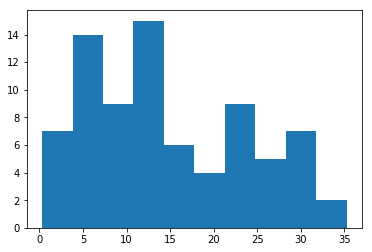

In [9]:
print(max(runaways['mage'] - runaways['age']))
print(min(runaways['mage'] - runaways['age']))
plt.hist(runaways['mage'] - runaways['age'])

__Max main-sequence age, mean luminosity for individual stars using power-law approximation to Padova evolutionary track.)__

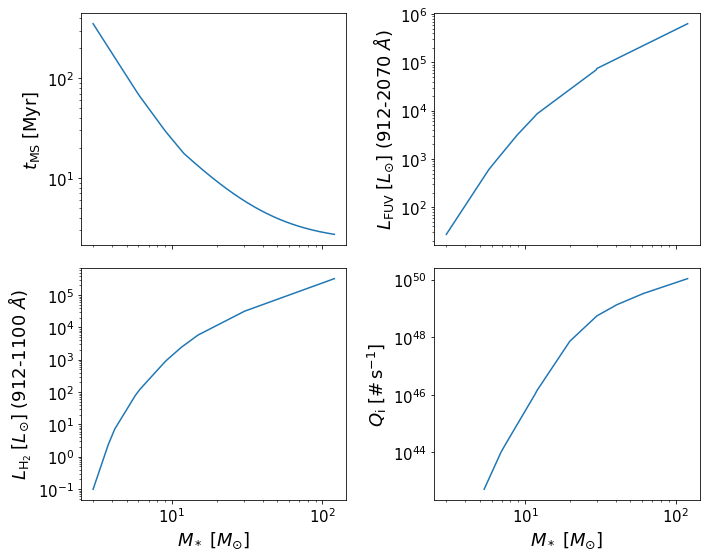

In [10]:
import matplotlib as mpl
import tigradpy as tp
MtoL = tp.mass_to_lum(model='Padova')
mass = np.linspace(3.0, 120.0, 300)

mpl.rcParams['font.size'] = 15.0
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True)
axes = axes.flatten()
plt.sca(axes[0])
plt.loglog(mass, MtoL.agemax_MS(mass))
plt.ylabel(r'$t_{\rm MS}\;[{\rm Myr}]$')
plt.sca(axes[1])
plt.loglog(mass, MtoL.LFUV(mass))
plt.ylabel(r'$L_{\rm FUV}\;[L_{\odot}]$ (912-2070 $\AA$)')
plt.sca(axes[2])
plt.loglog(mass, MtoL.LH2(mass))
plt.xlabel(r'$M_*\;[M_{\odot}]$')
plt.ylabel(r'$L_{{\rm{H}_2}}\;[L_{\odot}]$ (912-1100 $\AA$)')
plt.sca(axes[3])
plt.loglog(mass, MtoL.Qi(mass))
plt.xlabel(r'$M_*\;[M_{\odot}]$')
plt.ylabel(r'$Q_{\rm i}\;[\#\,{\rm s}^{-1}]$')
plt.tight_layout()

In [11]:
for t in range(310,312):
    print gen_cgfiles(probname, pid, t )[1]
    spa = pa.read_starvtk(gen_cgfiles(probname, pid, t )[1])
    if spa.shape[0] == 0:
        continue

    runaways, clusters = find_activeparticles(spa)

/tigress/changgoo/R8_4pc_newacc/starpar/R8_4pc_newacc.0310.starpar.vtk
/tigress/changgoo/R8_4pc_newacc/starpar/R8_4pc_newacc.0311.starpar.vtk


__Ratio between mage and age for "cluster particles"__

Text(0,0.5,'mage / age')

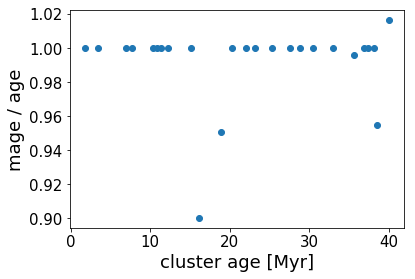

In [12]:
plt.plot(clusters['age'],clusters['mage']/clusters['age'], 'o')
plt.xlabel('cluster age [Myr]')
plt.ylabel('mage / age')
# Why is mage > age at 311?

__MS age and ZAMS relation__

(1.0, 5000.0)

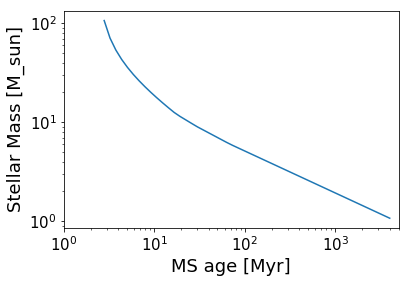

In [13]:
import tigradpy as tp
from tigradpy.util.piecewisepowerlaw import PiecewisePowerlaw

mass_range = np.array([1.2, 3.0, 6.0, 9.0, 12.0, 120.0])
MtoL = tp.mass_to_lum(model='Padova')
# age_range = np.flip(MtoL.agemax_MS(mass_range))
# coeff = np.array([7.65e3, 4.73e3, 2.76e3, 1.59e3, 7.60e2])
age = np.logspace(np.log10(2.8), np.log10(4e3))
#print age
plt.loglog(age, MtoL.age_to_mass(age))
plt.xlabel('MS age [Myr]')
plt.ylabel('Stellar Mass [M_sun]')
plt.xlim(1e0, 5e3)

In [14]:
num = 240
for t in range(num, num+1):
    print gen_cgfiles(probname, pid, t )[1]
    spa = pa.read_starvtk(gen_cgfiles(probname, pid, t )[1])
    if spa.shape[0] == 0:
        continue

    runaways, clusters = find_activeparticles(spa)
    

/tigress/changgoo/R8_4pc_newacc/starpar/R8_4pc_newacc.0240.starpar.vtk


In [15]:
age = np.array(runaways['mage'] - runaways['age'])
age = age[(age > 2.73)]
mass = MtoL.age_to_mass(age)

__From (estimated) runaway MS lifetime to mass. How does the mass histogram look like?__

[]

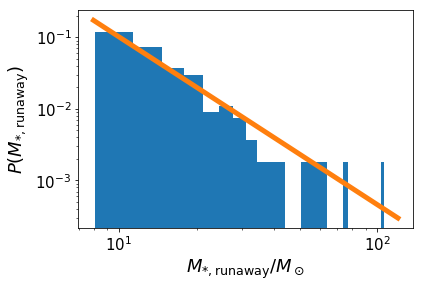

In [16]:
plt.hist(mass, density=True, bins=30)
#pdf,mass = pull_runawaymass(3000)
# Sanity check on inverse and mean methods
xs = np.linspace(8.,120., 100)
#plt.hist(mass, density=True, bins=60)
plt.plot(xs, pdf(xs), lw=5)

plt.xlabel (r'$M_{*,{\rm runaway}}/M_\odot$')
plt.ylabel (r'$P(M_{*,{\rm runaway}})$')
plt.loglog()
#print(mass.mean(), get_meanrunawaymass())


__Make a toy model for simple stellar population using Padova mass-luminosity relation__


__For FUV, consider all stars with $M > 1.8 M_{\odot}$__

__For EUV, consider all stars with $M > 5.0 M_{\odot}$__

__for which we have mean luminosity, MS lifetime information as a function of initial stellar mass.__

__Adopt Kroupa IMF__

Tools to work with IMF: https://github.com/keflavich/imf


In [17]:
import os
sys.path.append(os.path.join(os.path.expanduser('~'),'imf'))
import imf 
kroupa = imf.Kroupa()

mmax = 120.0
cutoff0 = 5.0
cutoff1 = 1.8
over_cutoff_frac0 = (kroupa.m_integrate(cutoff0, mmax)[0] /
                     kroupa.m_integrate(kroupa.mmin, mmax)[0])
over_cutoff_frac1 = (kroupa.m_integrate(cutoff1, mmax)[0] /
                     kroupa.m_integrate(kroupa.mmin, mmax)[0])

print('over_cutoff_frac0',over_cutoff_frac0)
print('over_cutoff_frac1',over_cutoff_frac1)

('over_cutoff_frac0', 0.2663895245589496)
('over_cutoff_frac1', 0.421849044893804)


In [18]:
pdf,mass0 = pull_runawaymass(10000, lmass=cutoff0)
pdf,mass1 = pull_runawaymass(10000, lmass=cutoff1)
agemax0 = MtoL.agemax_MS(mass0)
agemax1 = MtoL.agemax_MS(mass1)
age = np.arange(0.0, 40.0, 0.1)
Qitot = []
LFUVtot = []
MtoL.model = 'Padova'
for age_ in age:
    mass = mass0[agemax0 > age_]
    Qitot.append(MtoL.Qi(mass).sum())
    mass = mass1[agemax1 > age_]
    LFUVtot.append(MtoL.LFUV(mass).sum())
    
Xi = over_cutoff_frac0*np.array(Qitot)/mass0.sum()
Psi = over_cutoff_frac1*np.array(LFUVtot)/mass1.sum()

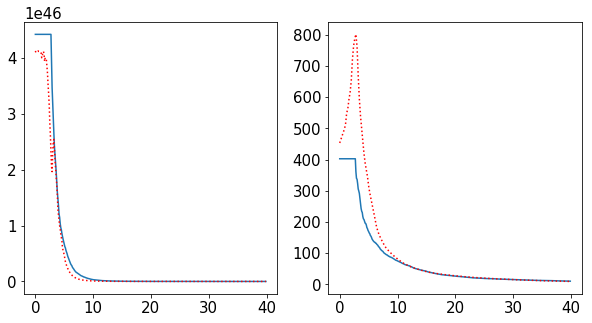

In [19]:
# overplot SB99 result using red dotted lines
MtoL.model = 'SB99'

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(axes[0])
plt.plot(age, Xi)
plt.plot(age, MtoL.calc_Qi(1.0, age), 'r:')
#plt.yscale('log')
plt.sca(axes[1])
plt.plot(age, Psi)
plt.plot(age, MtoL.calc_LFUV(1.0, age), 'r:')
#plt.yscale('log')

__Left: IMF-averaged ionizing photon rate per unit solar mass (number/Msun/sec)__

__Right: IMF-averaged FUV luminosity per unit solar mass (Lsun/Msun)__

__overplotted SB99 result using red dotted lines__


* __Comments__
    * Change in optical depth around sources - Ionizing radiation field highly variable - photoionization rate fluctuate with time.
    * If the timescale for recombination at high altitude is long compared to the timescale for radiation variability, actual volume of ionized gas is likely to be higher than the one obtained by ionization-recombination equilibrium.
    * Nevertheless, we can make a rough estimate of how many ionizing photons (or massive stars) need to travel above the gas scale height per unit time to keep the gas at high altitude ionized, and compare that with simulation results.
        * As a function of $\tau_{\perp, {\rm dust}}$ and/or $\langle \alpha_{\rm B}n_e^2 \rangle(z)$?
        * __Can runaways make a significant difference?__
        * And express these conditions in terms of....for example $\Sigma$, $H_{\rm gas}$ and $L_{{\rm H}\alpha}$...? Need a model for $f_{\rm esc,{\rm scale height}}$ and $f_{\rm esc,cloud}$.


* __Questions__
    * How is time bomb set?
    * Does ejection velocity of individual runaways correlate with its time bomb (or mass)? __O stars are not likely to have high velocity (Fig 3 in Eldridge+11).__
    * Aren't we overestimating the fraction of runaways? Compared to observations and Eldridge+11?

    
* __TODO__
    * Raytracing
        * dmaxPP as a function of $\mu$
        * Need to further reduce the cost of first ray-trace:
            * (1) May use coarser angular resolution
            * (2) Trace rays in order from most to least luminous ones.
            * (3) Store rate coefficients in arrays
        
    * Simulations (models)
        * Low-resolution (16pc) tall-box models __with and without runaways__
            * Estimate cost. Is it plausible?
            
        * Analysis
            * 
    

* Synthetic observations of FUV and Halpha possible?
* Module for all sky observation using ART

* density zprof profile as a function of time

* 